In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Make sure to import pandas for the confusion matrix

In [3]:
# --- 1. Data Loading ---
# (This part remains the same)
data_train = np.load('dataset/train_set.npz', allow_pickle=True)
x_train_np = data_train['arr_0']
y_train_np = data_train['arr_1']

data_test = np.load('dataset/test_set.npz', allow_pickle=True)
x_test_np = data_test['arr_0']
y_test_np = data_test['arr_1']


In [4]:
# --- 2. Data Augmentation and Preprocessing (Corrected) ---

# Define transformations for data augmentation ONLY
# Note: ToTensor is included to work with PIL images, but we'll convert back to numpy
aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.ToTensor()
])

# --- Augment Training Data ---
x_aug_train = []
y_aug_train = []
for img, label in zip(x_train_np, y_train_np):
    for _ in range(70): # Create 70 augmented versions
        aug_img_tensor = aug_transform(img)
        # Permute tensor from (C, H, W) to (H, W, C) and convert to numpy
        aug_img_np = aug_img_tensor.permute(1, 2, 0).numpy() * 255
        x_aug_train.append(aug_img_np.astype(np.uint8))
        y_aug_train.append(label)

# --- Augment Test Data ---
x_aug_test = []
y_aug_test = []
for img, label in zip(x_test_np, y_test_np):
    for _ in range(20): # Create 20 augmented versions
        aug_img_tensor = aug_transform(img)
        aug_img_np = aug_img_tensor.permute(1, 2, 0).numpy() * 255
        x_aug_test.append(aug_img_np.astype(np.uint8))
        y_aug_test.append(label)

# --- Combine original and augmented data ---
x_train_combined = np.concatenate((x_train_np, np.array(x_aug_train)))
y_train_combined = np.concatenate((y_train_np, np.array(y_aug_train)))
x_test_combined = np.concatenate((x_test_np, np.array(x_aug_test)))
y_test_combined = np.concatenate((y_test_np, np.array(y_aug_test)))

# --- Preprocess ALL images uniformly ---
def preprocess_all(images):
    processed_images = []
    for img in images:
        img = cv2.resize(img, (128, 128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed_images.append(img)
    return np.array(processed_images)

x_train_processed = preprocess_all(x_train_combined)
x_test_processed = preprocess_all(x_test_combined)

# --- Normalize and Encode Labels ---
x_train = x_train_processed / 255.0
x_test = x_test_processed / 255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_combined)
y_test = label_encoder.transform(y_test_combined)

# --- Convert to PyTorch Tensors and create DataLoaders ---
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# The rest of your code (Model Definition, Training, Evaluation) remains the same.

In [5]:
# --- 3. Model Definition ---
class ParkinsonDetectionModel(nn.Module):
    def __init__(self):
        super(ParkinsonDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=9, stride=3)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, stride=1, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=7, stride=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [6]:
# --- 4. Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

model = ParkinsonDetectionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3.15e-5, weight_decay=0.001)

history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

epochs = 70
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, "
          f"Accuracy: {train_acc:.2f}%, Val_Loss: {val_loss:.4f}, "
          f"Val_Accuracy: {val_acc:.2f}%")

# --- Save trained model ---
model_path = "parkinson_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Using:  cuda
Epoch 1/70 - Loss: 0.6968, Accuracy: 49.90%, Val_Loss: 0.6953, Val_Accuracy: 50.00%
Epoch 2/70 - Loss: 0.6958, Accuracy: 49.84%, Val_Loss: 0.6942, Val_Accuracy: 50.00%
Epoch 3/70 - Loss: 0.6954, Accuracy: 49.67%, Val_Loss: 0.6940, Val_Accuracy: 50.00%
Epoch 4/70 - Loss: 0.6937, Accuracy: 50.18%, Val_Loss: 0.6934, Val_Accuracy: 50.00%
Epoch 5/70 - Loss: 0.6949, Accuracy: 49.73%, Val_Loss: 0.6934, Val_Accuracy: 50.00%
Epoch 6/70 - Loss: 0.6955, Accuracy: 49.00%, Val_Loss: 0.6935, Val_Accuracy: 50.00%
Epoch 7/70 - Loss: 0.6955, Accuracy: 49.32%, Val_Loss: 0.6934, Val_Accuracy: 50.00%
Epoch 8/70 - Loss: 0.6934, Accuracy: 50.78%, Val_Loss: 0.6932, Val_Accuracy: 50.00%
Epoch 9/70 - Loss: 0.6945, Accuracy: 49.43%, Val_Loss: 0.6933, Val_Accuracy: 50.00%
Epoch 10/70 - Loss: 0.6954, Accuracy: 48.61%, Val_Loss: 0.6932, Val_Accuracy: 50.00%
Epoch 11/70 - Loss: 0.6944, Accuracy: 49.51%, Val_Loss: 0.6928, Val_Accuracy: 50.00%
Epoch 12/70 - Loss: 0.6944, Accuracy: 50.10%, Val_Loss: 0.692

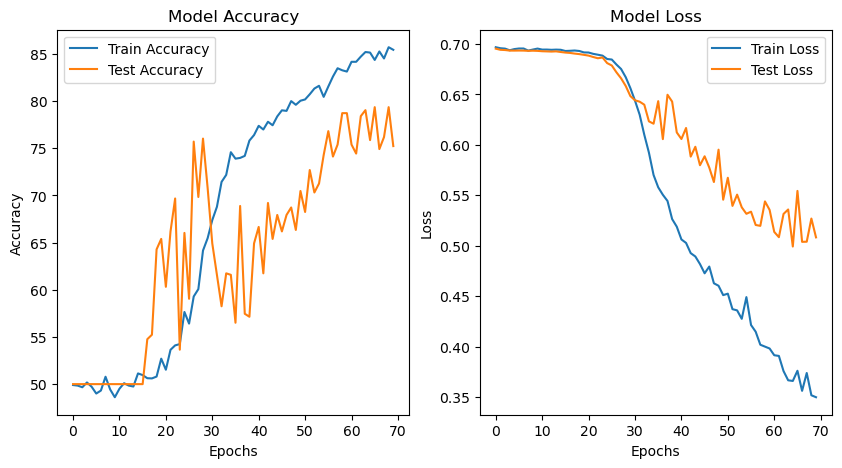

In [7]:
# --- 5. Evaluation ---
# Loss and Accuracy Plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       315
           1       0.78      0.70      0.74       315

    accuracy                           0.75       630
   macro avg       0.75      0.75      0.75       630
weighted avg       0.75      0.75      0.75       630



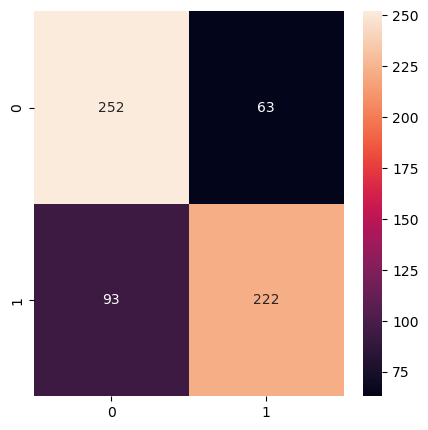

In [9]:
# Classification Report and Confusion Matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

matrix = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

C:\Users\Reach\AppData\Local\Temp\ipykernel_13876\1810661349.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("parkinson_model.pth", map_

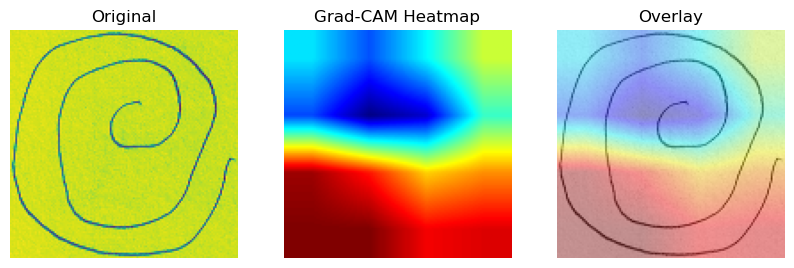

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Load the trained model ---
model = ParkinsonDetectionModel().to(device)
model.load_state_dict(torch.load("parkinson_model.pth", map_location=device))
model.eval()

# --- Grad-CAM helper class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_image)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[:, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# --- Choose the last convolutional layer for Grad-CAM ---
target_layer = model.conv4

gradcam = GradCAM(model, target_layer)

# --- Pick one test image ---
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)

# Generate Grad-CAM heatmap
cam = gradcam.generate(image)

# Convert tensor to image
image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Resize heatmap to match image
heatmap = cv2.resize(cam, (image_np.shape[1], image_np.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

# Overlay heatmap on image
overlay = 0.4 * heatmap + 0.6 * image_np
overlay = np.clip(overlay, 0, 1)

# --- Plot results ---
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis('off')

plt.show()

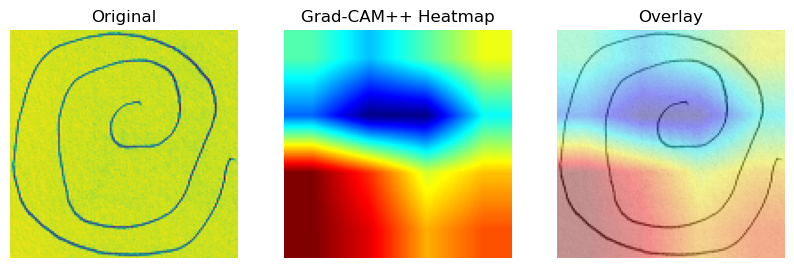

In [13]:
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_image)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[:, class_idx]
        loss.backward()

        gradients = self.gradients
        activations = self.activations
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2) * 2 + \
            (activations * gradients.pow(3)).sum(dim=(2, 3), keepdim=True)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alphas = alpha_num / alpha_denom

        weights = (alphas * F.relu(gradients)).sum(dim=(2, 3), keepdim=True)
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# --- Initialize Grad-CAM++ ---
gradcam_pp = GradCAMPlusPlus(model, model.conv4)

# --- Pick one test image ---
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)

# Generate Grad-CAM++ heatmap
cam_pp = gradcam_pp.generate(image)

# Convert tensor to image
image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Resize and overlay
heatmap_pp = cv2.resize(cam_pp, (image_np.shape[1], image_np.shape[0]))
heatmap_pp = cv2.applyColorMap(np.uint8(255 * heatmap_pp), cv2.COLORMAP_JET)
heatmap_pp = np.float32(heatmap_pp) / 255
overlay_pp = 0.4 * heatmap_pp + 0.6 * image_np
overlay_pp = np.clip(overlay_pp, 0, 1)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM++ Heatmap")
plt.imshow(heatmap_pp)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay_pp)
plt.axis('off')

plt.show()

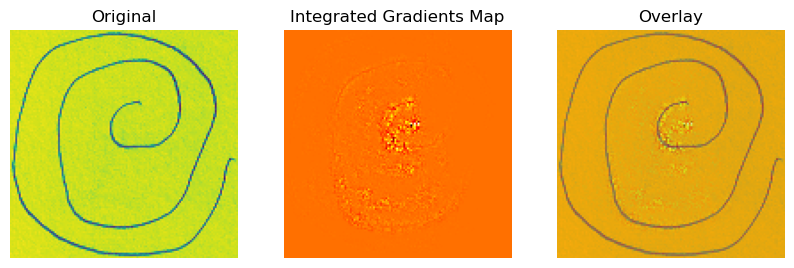

In [14]:
from torch.autograd import Variable

def integrated_gradients(model, input_image, target_class=None, baseline=None, steps=50):
    model.eval()

    if baseline is None:
        baseline = torch.zeros_like(input_image).to(device)
    
    # Scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps+1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad = True

    # Forward pass
    outputs = model(scaled_inputs)
    
    if target_class is None:
        target_class = outputs[steps].argmax().item()

    # Backward pass
    loss = outputs[:, target_class].sum()
    loss.backward()

    grads = scaled_inputs.grad
    avg_grads = grads.reshape((steps+1, ) + grads.shape[1:]).mean(dim=0)

    # Integrated gradients approximation
    integrated_grads = (input_image - baseline) * avg_grads
    return integrated_grads.squeeze().cpu().numpy()

# --- Pick one test image ---
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)

# Generate IG attribution map
ig_attr = integrated_gradients(model, image)

# Normalize for visualization
ig_attr_norm = (ig_attr - ig_attr.min()) / (ig_attr.max() - ig_attr.min() + 1e-8)

# Convert image to numpy for plotting
image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Plot IG results
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Integrated Gradients Map")
plt.imshow(ig_attr_norm, cmap='hot')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(image_np)
plt.imshow(ig_attr_norm, cmap='hot', alpha=0.5)
plt.axis('off')

plt.show()

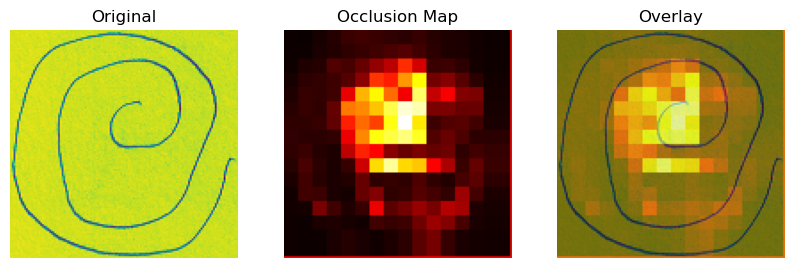

In [15]:
import numpy as np

def occlusion_sensitivity(model, image, target_class=None, patch_size=10, stride=5):
    model.eval()
    _, _, H, W = image.shape
    heatmap = np.zeros((H, W))

    if target_class is None:
        with torch.no_grad():
            pred = model(image)
            target_class = pred.argmax().item()

    for y in range(0, H - patch_size, stride):
        for x in range(0, W - patch_size, stride):
            occluded_image = image.clone()
            occluded_image[:, :, y:y+patch_size, x:x+patch_size] = 0  # black patch
            
            with torch.no_grad():
                output = model(occluded_image)
                score = output[0, target_class].item()

            heatmap[y:y+patch_size, x:x+patch_size] = score

    # Normalize so high importance = high drop in score
    heatmap = np.max(heatmap) - heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    return heatmap

# --- Pick one test image ---
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)

# Get occlusion sensitivity map
occ_map = occlusion_sensitivity(model, image, patch_size=15, stride=8)

# Convert image for plotting
image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Plot results
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Occlusion Map")
plt.imshow(occ_map, cmap='hot')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(image_np)
plt.imshow(occ_map, cmap='hot', alpha=0.5)
plt.axis('off')

plt.show()


In [22]:
import torch

# Load the state dict without strict model loading
state_dict = torch.load("parkinson_model.pth", map_location="cpu")

print("🔍 Keys and shapes in saved model:\n")
for key, value in state_dict.items():
    print(f"{key}: {tuple(value.shape)}")

🔍 Keys and shapes in saved model:

conv1.weight: (128, 1, 5, 5)
conv1.bias: (128,)
conv2.weight: (64, 128, 5, 5)
conv2.bias: (64,)
conv3.weight: (32, 64, 3, 3)
conv3.bias: (32,)
conv4.weight: (32, 32, 3, 3)
conv4.bias: (32,)
fc1.weight: (64, 32)
fc1.bias: (64,)
fc2.weight: (2, 64)
fc2.bias: (2,)


C:\Users\Reach\AppData\Local\Temp\ipykernel_13876\4015198747.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("parkinson_model.pth", map_location=

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Reach\AppData\Local\Temp\ipykernel_13876\2168594678.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img.astype('uint8'), 'RGB')
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.48it/s]


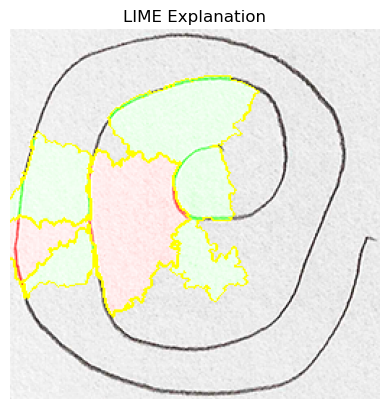

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 1️⃣ Exact architecture from your print(model)
class ParkinsonDetectionModel(nn.Module):
    def __init__(self):
        super(ParkinsonDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=9, stride=3)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=7, stride=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(32, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# 2️⃣ Load model with safe weights loading
model = ParkinsonDetectionModel()
state_dict = torch.load("parkinson_model.pth", map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# 3️⃣ Transform for single-channel input
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Match training size
    transforms.ToTensor()
])

# 4️⃣ Prediction function for LIME
def predict_fn(images):
    batch = []
    for img in images:
        pil_img = Image.fromarray(img.astype('uint8'), 'RGB')
        img_tensor = transform(pil_img).unsqueeze(0)
        batch.append(img_tensor)
    batch = torch.cat(batch)
    with torch.no_grad():
        outputs = model(batch)
        probs = torch.softmax(outputs, dim=1).numpy()
    return probs

# 5️⃣ Load a sample image
img_path = "test_image.png"  # Replace with your image path
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

# 6️⃣ Run LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# 7️⃣ Visualize explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.01
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()

C:\Users\Reach\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\Users\Reach\AppData\Local\Temp\ipykernel_13876\2563390353.py:98: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


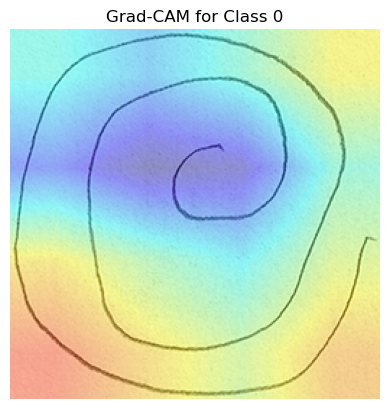

In [26]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import cv2

# ✅ Use the same model definition as in your LIME code
class ParkinsonDetectionModel(nn.Module):
    def __init__(self):
        super(ParkinsonDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=9, stride=3)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=7, stride=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(32, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Load model
model = ParkinsonDetectionModel()
state_dict = torch.load("parkinson_model.pth", map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# Transform for test image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Grad-CAM hook storage
gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

# Choose last conv layer for Grad-CAM
target_layer = model.conv4

def forward_hook(module, input, output):
    global activations
    activations = output

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(lambda m, gi, go: save_gradient(go[0]))

# Load image
img_path = "test_image.png"  # Replace with your path
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 1, 128, 128)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Backward pass for Grad-CAM
model.zero_grad()
class_score = output[0, pred_class]
class_score.backward()

# Compute Grad-CAM
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = activations.detach()

for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)

# Convert heatmap to numpy
heatmap = heatmap.numpy()

# Overlay on original image
heatmap = cv2.resize(heatmap, (image.width, image.height))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(np.array(image), 0.6, heatmap, 0.4, 0)

# Show
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM for Class {pred_class}")
plt.axis('off')
plt.show()
